In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2_contingency
import scipy.stats as stats
import seaborn as sns

In [2]:
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')
df.shape # (2443651, 9)
df.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

In [ ]:
## 1.1 **Crosstab Analysis**:
# Crear una tabla cruzada de `category` y el estado `isBestSeller`    
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Are there categories where being a best-seller is more prevalent? 

# Calcula la proporción de best-sellers dentro de cada categoría
crosstab['proportion_bestSeller'] = crosstab[True] / (crosstab[True] + crosstab[False])

# Ordena las categorías por la proporción de best-sellers en orden descendente 
sorted_crosstab = crosstab.sort_values('proportion_bestSeller', ascending=False)

# Muestra los resultados
print(sorted_crosstab)

# Grocery and Smart Home Security & Lightning

isBestSeller                      False  True  proportion_bestSeller
category                                                            
Grocery                            9008   556               0.058135
Smart Home Security & Lighting       98     6               0.057692
Health & Personal Care             9017   552               0.057686
Mobile Phone Accessories            248    11               0.042471
Power & Hand Tools                 8353   306               0.035339
...                                 ...   ...                    ...
CD, Disc & Tape Players            8798     0               0.000000
General Music-Making Accessories    259     0               0.000000
Snowboard Boots                    1449     0               0.000000
Boxes & Organisers                  911     0               0.000000
eBook Readers & Accessories         246     0               0.000000

[296 rows x 3 columns]


2.1 **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [5]:
# Crear una tabla de contingencia
contingency_table = pd.crosstab(df['category'], df['isBestSeller'])

# Realizar el test de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Mostrar los resultados
print(f"Chi2: {chi2}")
print(f"p-value: {p}")

# Interpretar el p-valor
if p < 0.05:
    print("There is a significant association between product category and best-seller status.")
else:
    print("There is no significant association between product category and best-seller status.")

Chi2: 36540.20270061387
p-value: 0.0
There is a significant association between product category and best-seller status.


In [6]:
# Calcular Cramér's V
cramers_v = np.sqrt(chi2 / (contingency_table.sum().sum() * (min(contingency_table.shape) - 1)))

# Mostrar el resultado de Cramér's V
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.1222829439760564


3.1 **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

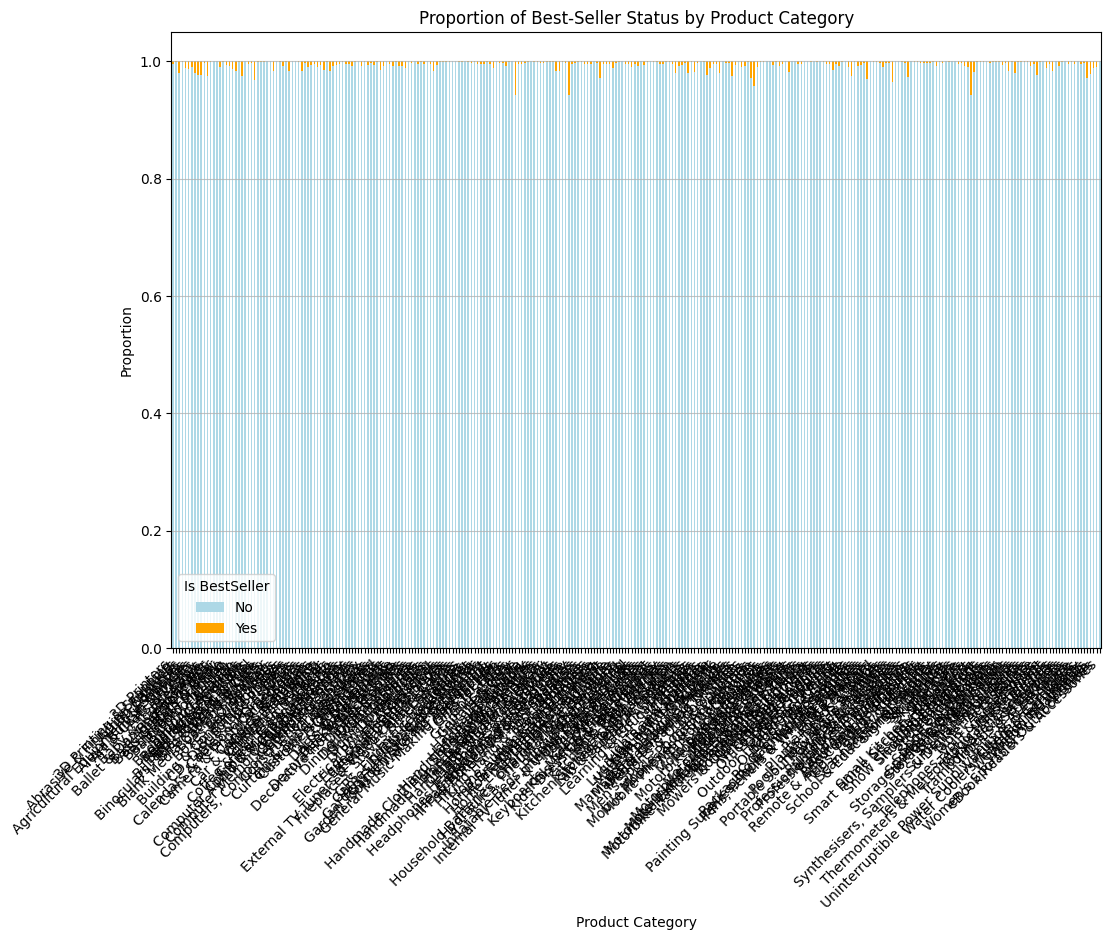

In [7]:
# Crear una tabla cruzada de categoría de producto y estado de best-seller
crosstab = pd.crosstab(df['category'], df['isBestSeller'], normalize='index') 
# normalize='index' convierte las cuentas en proporciones, de modo que cada barra sume a 1.

# Dibujar un gráfico de barras apiladas
crosstab.plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightblue', 'orange'])
plt.title('Proportion of Best-Seller Status by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is BestSeller', labels=['No', 'Yes'])
plt.grid(axis='y', alpha=0.75)

# Mostrar el gráfico
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*


In [8]:
# Calcular Q1 (primer cuartil)
Q1 = df['price'].quantile(0.25)

# Calcular Q3 (tercer cuartil)
Q3 = df['price'].quantile(0.75)

# Calcular el IQR (Rango Intercuartil)
IQR = Q3 - Q1

# Determinar los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers y crear un nuevo DataFrame
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Imprimir el número de productos antes y después de la eliminación de outliers
print(f"Original number of products: {len(df)}")
print(f"Number of products after removing outliers: {len(df_no_outliers)}")

Original number of products: 2443651
Number of products after removing outliers: 2115963


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

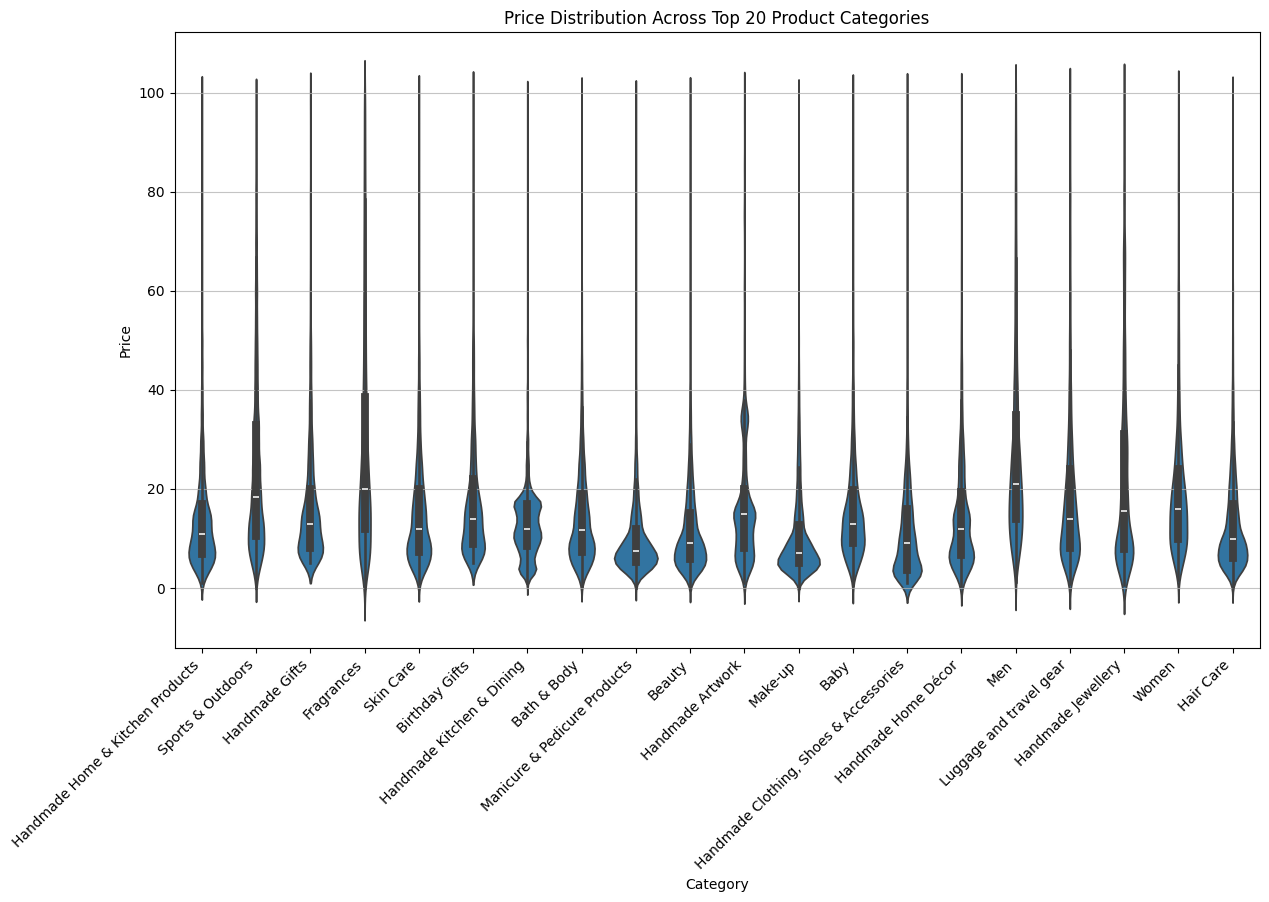

Category with the highest median price: Desktop PCs
Median price in this category: 74.0


In [9]:
# Obtener las 20 categorías más comunes
top_20_categories = df_no_outliers['category'].value_counts().head(20).index

# Filtrar el DataFrame
df_top_20 = df_no_outliers[df_no_outliers['category'].isin(top_20_categories)]

# Violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='category', y='price', data=df_top_20)
plt.title('Price Distribution Across Top 20 Product Categories')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price')
plt.xlabel('Category')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calcular la mediana del precio para cada categoría
median_prices = df_no_outliers.groupby('category')['price'].median()

# Encontrar la categoría con el precio mediano más alto
highest_median_category = median_prices.idxmax()
highest_median_price = median_prices.max()
# idxmax() y max() son usados respectivamente para 
# identificar la categoría con el precio mediano más alto.

print(f"Category with the highest median price: {highest_median_category}")
print(f"Median price in this category: {highest_median_price}")

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

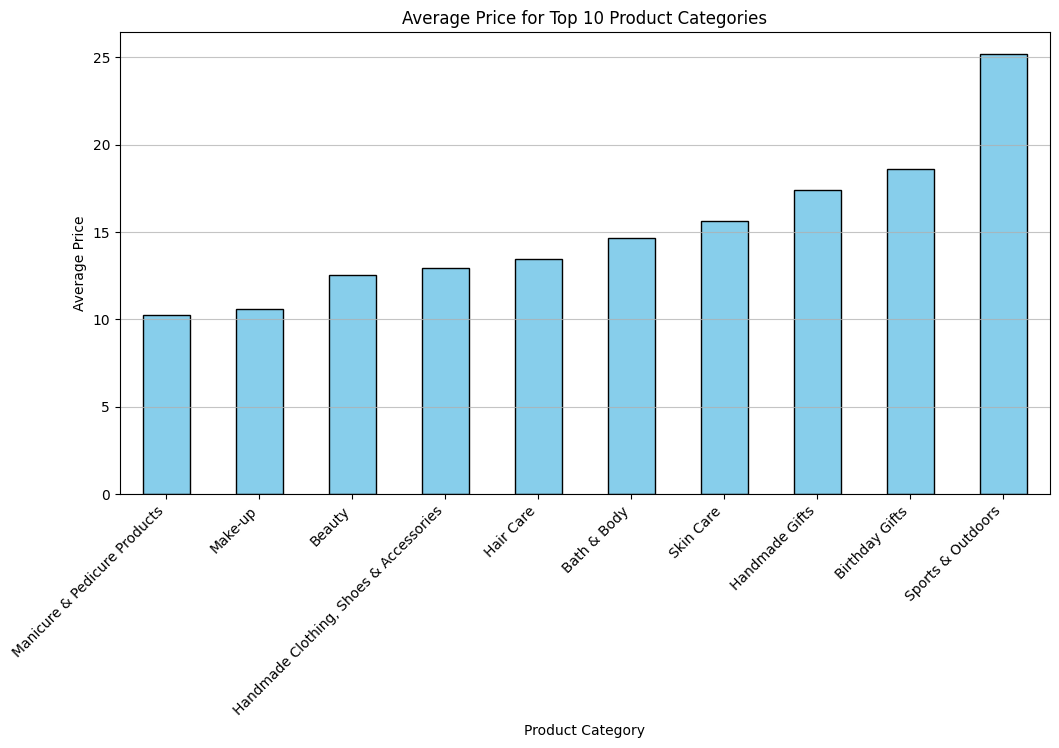

Category with the highest average price: Motherboards
Average price in this category: 68.77243243243242


In [10]:
# Calcular el número de productos por categoría
top_10_categories = df_no_outliers['category'].value_counts().head(10).index

# Filtrar el DataFrame
df_top_10 = df_no_outliers[df_no_outliers['category'].isin(top_10_categories)]

# Calcular el precio promedio para estas categorías
average_prices_top_10 = df_top_10.groupby('category')['price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
average_prices_top_10.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Price for Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calcular el precio promedio para cada categoría
average_prices = df_no_outliers.groupby('category')['price'].mean()

# Encontrar la categoría con el precio promedio más alto
highest_average_category = average_prices.idxmax()
highest_average_price = average_prices.max()

print(f"Category with the highest average price: {highest_average_category}")
print(f"Average price in this category: {highest_average_price}")

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17968\3721097464.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='stars', data=df_top_10, palette='Set2')


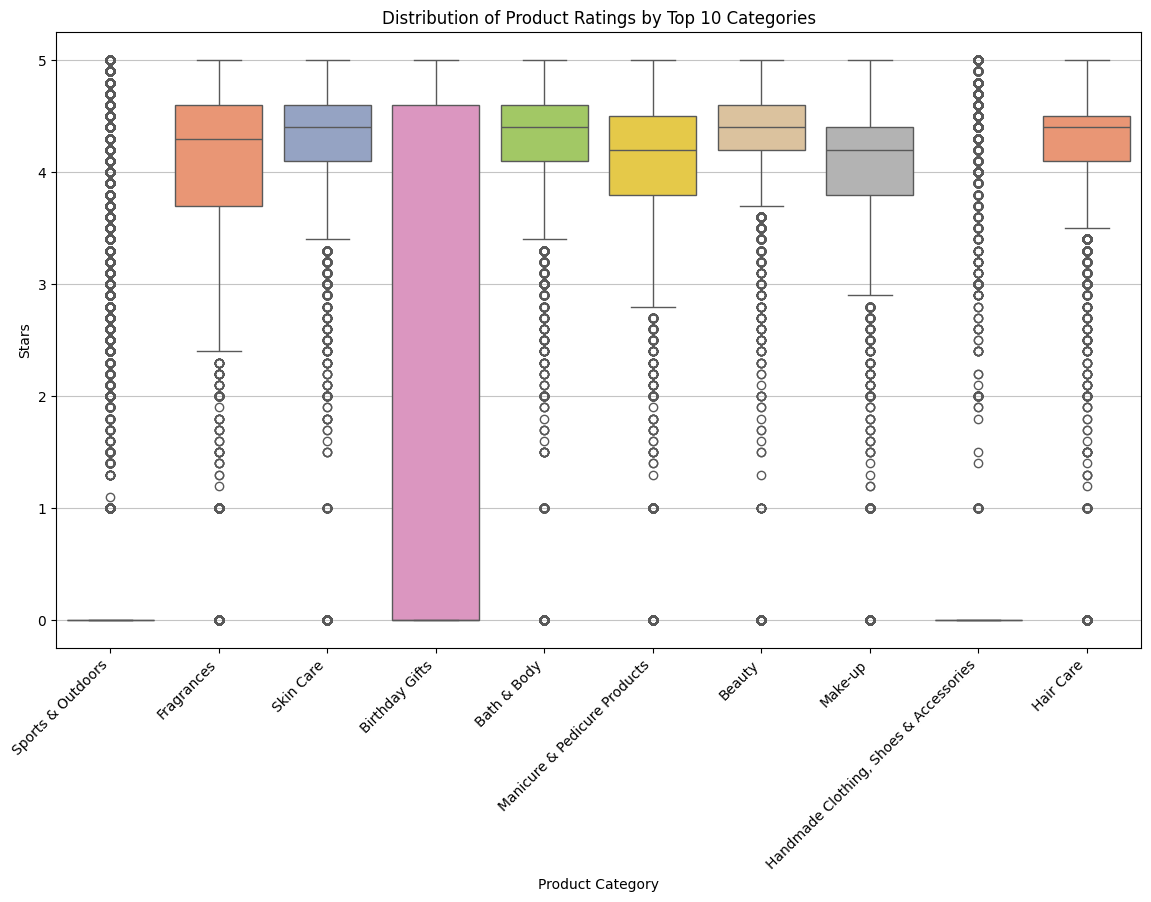

Category with the highest median rating: Computer Memory
Median rating in this category: 4.7


In [17]:
# Obtener las 10 categorías más comunes
top_10_categories = df['category'].value_counts().head(10).index

# Filtrar el DataFrame
df_top_10 = df[df['category'].isin(top_10_categories)]

# Crear un boxplot para la columna de calificaciones por categoría
plt.figure(figsize=(14, 8))
sns.boxplot(x='category', y='stars', data=df_top_10, palette='Set2')
plt.title('Distribution of Product Ratings by Top 10 Categories')
plt.xlabel('Product Category')
plt.ylabel('Stars')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calcular la mediana de las calificaciones para cada categoría
median_ratings = df.groupby('category')['stars'].median()

# Encontrar la categoría con la calificación mediana más alta
highest_median_category = median_ratings.idxmax()
highest_median_rating = median_ratings.max()

print(f"Category with the highest median rating: {highest_median_category}")
print(f"Median rating in this category: {highest_median_rating}")

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?


In [13]:
# Calcular el coeficiente de correlación entre precio y estrellas
correlation = df['price'].corr(df['stars'])

# Mostrar el resultado
print(f"Correlation coefficient between price and stars: {correlation}")

if correlation == 1:
    print("Correlación positiva perfecta.")
elif correlation == -1:
    print("Correlación negativa perfecta.")
elif correlation == 0:
    print("No hay correlación.")
elif 0 < abs(correlation) < 0.3:
    print("Correlación débil.")
elif 0.3 <= abs(correlation) < 0.7:
    print("Correlación moderada.")
else:
    print("Correlación fuerte.")

Correlation coefficient between price and stars: -0.12490673262148386
Correlación débil.


2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

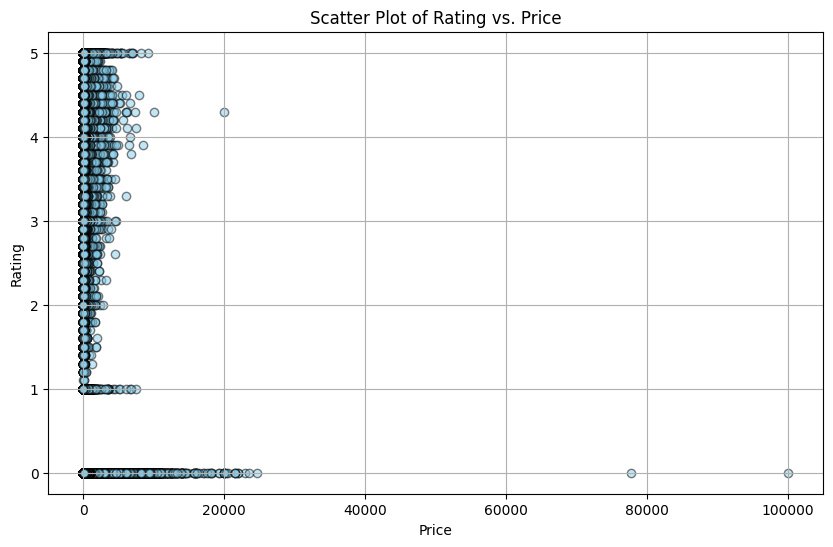

In [19]:
# Crear un scatter plot (gráfico de dispersión) entre rating y precio
plt.figure(figsize=(10, 6))
plt.scatter(df['price'], df['stars'], alpha=0.5, color='skyblue', edgecolor='black')
plt.title('Scatter Plot of Rating vs. Price')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

plt.show()

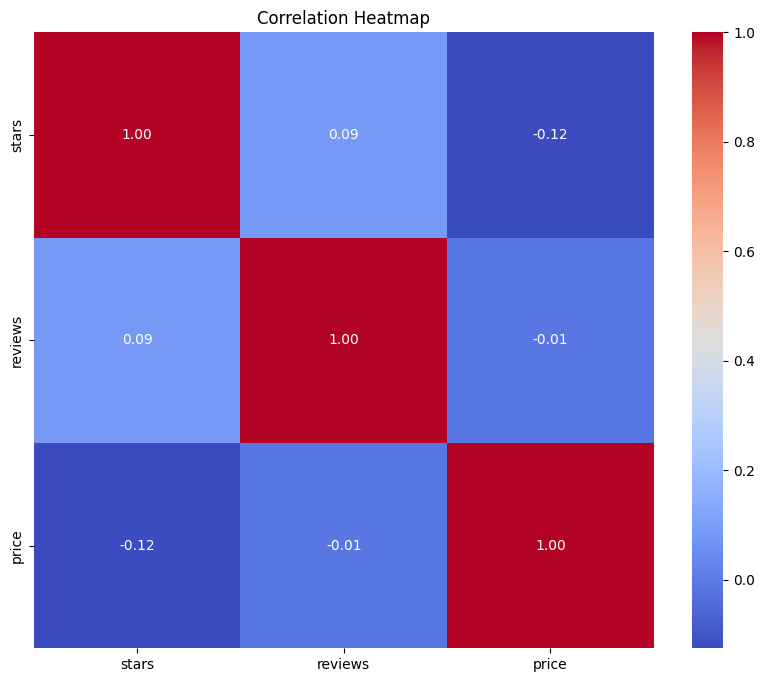

In [23]:
# Calcular la matriz de correlación
df_clean = df.dropna(subset=['stars', 'reviews', 'price'])
correlation_matrix = df_clean[['stars', 'reviews', 'price']].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



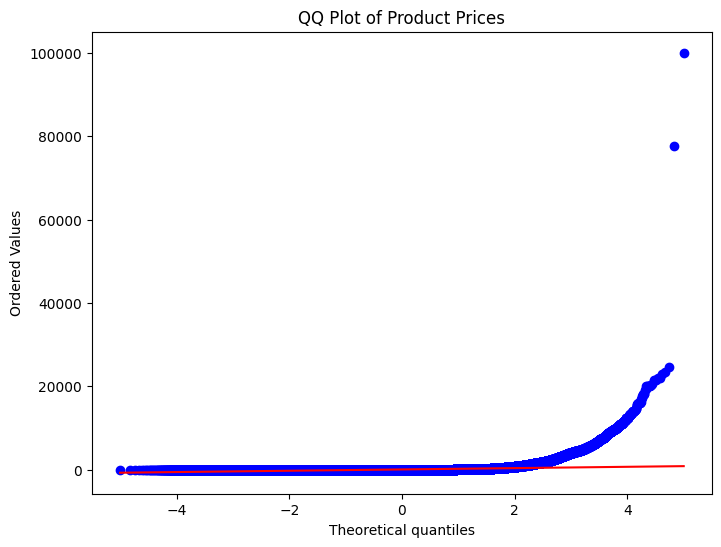

In [26]:
# Crear un QQ plot para verificar la normalidad de los precios
plt.figure(figsize=(8, 6))
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('QQ Plot of Product Prices')
plt.show()

3. **Bonus**:
- Do the same analysis without taking out the outliers. What are your insights?

In [ ]:
# Without taking out the outliers, all the data seem to be more dispersed and results are not so easy to 
# interpret. It is important to use techniques such as IQR and sigma levels to identify outliers and decide
# whether to keep them or remove them from the analysis.